In [134]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Modelling
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.utils import to_categorical 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold


# Geolocation libraries
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from global_land_mask import globe

In [2]:
pd.set_option('display.max_columns', None)

## Information

This Notebook explores the possibility of using observation meta-data to support decision making locally.

Modern wildlife classification algorithms follow a taxonomic heirarchical approach to classifying wildlife species. Meaning that given an image, the algorithm attempt to classify the Kingdom -> Phylum -> Class -> Order -> Family -> Genus -> Species. 

Learning from the global exploratory data analysis, whereby meta data by itself is not sufficeint toclassify observations having acheived a 25% accuracy accross 200 species. 

Instead, the metadata will be used to support the image classification algorithm at each heirarchical level. Specifically multiple sources [1](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.5256), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8035030/) indicate that classifiers often struggle to classify similar looking, sympatric (occuraing in the same, or overlapping geographic areas) species.

Based on this knowledge and the heirarchical approach, meta data models are to be trained on each heirarchical level to determine at which taxonomic level they may provide insightful information that could improve classification of similar looking and sympatric species.

In [3]:
file_path = '../../data/obs_and_meta/processed/'

### Proboscidia Observations

In [4]:
proboscidia_df = pd.read_csv(file_path + 'proboscidia_train.csv', index_col=0)

In [5]:
proboscidia_df.head()

,observed_on,local_time_observed_at,latitude,longitude,positional_accuracy,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id,taxon_kingdom_name,taxon_phylum_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name
id,,,,,,,,,,,,,,,,,,,,
16344,2007-11-30,2007-11-30 22:52:00+02:00,-17.946449,25.100015,NaN,30699.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17097,2007-11-16,2007-11-16 20:05:00+02:00,-18.422570,24.012110,NaN,30649.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17099,2007-11-16,2007-11-17 00:27:00+02:00,-19.196529,23.837842,NaN,30598.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17110,2007-11-12,2007-11-12 20:23:00+02:00,-13.190468,31.680375,NaN,31045.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17119,2007-11-12,2007-11-12 23:12:00+02:00,-13.148463,31.648811,NaN,31045.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana


In [6]:
print("Shape: ", proboscidia_df.shape)
print("Columns: ", proboscidia_df.columns)

Shape:  (9891, 20)
Columns:  Index(['observed_on', 'local_time_observed_at', 'latitude', 'longitude',
       'positional_accuracy', 'public_positional_accuracy', 'image_url',
       'license', 'geoprivacy', 'taxon_geoprivacy', 'scientific_name',
       'common_name', 'taxon_id', 'taxon_kingdom_name', 'taxon_phylum_name',
       'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
       'taxon_genus_name', 'taxon_species_name'],
      dtype='object')


### Proboscidia Meta Data

In [7]:
meta_df = pd.read_csv(file_path + 'proboscidia_meta.csv', index_col=0)

In [8]:
meta_df.head()

,lat,long,observed_on,time_zone,elevation,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration_hourly,weathercode_hourly,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,weathercode_daily,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4126,-19.502735,23.298196,2009-07-25 10:58:00+02:00,Africa/Gaborone,946.0,2009-07-25T10:00,12.6,55.0,3.9,8.8,919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476.0,380.0,96.0,16.5,22.2,110.0,110.0,34.6,0.24,0,0.66,14.4,16.1,19.3,0.049,0.079,0.090,0,20.6,3.9,17.1,-0.2,0.0,0.0,0.0,0.0,2009-07-25T06:57,2009-07-25T18:09,17.0,37.4,132.0,19.05,4.18
16344,-17.946449,25.100015,2007-11-30 22:52:00+02:00,Africa/Gaborone,1032.0,2007-11-30T22:00,24.0,63.0,16.4,24.2,902.5,0.0,0.0,0.0,9.0,0.0,6.0,19.0,0.0,0.0,0.0,13.8,27.1,81.0,79.0,24.1,0.06,0,1.11,25.1,27.3,27.3,0.229,0.188,0.149,51,30.0,18.9,33.3,19.2,0.3,0.3,0.0,1.0,2007-11-30T05:33,2007-11-30T18:42,17.2,37.1,55.0,28.63,6.28
16346,-20.253259,25.194044,2007-11-30 00:03:00+02:00,Africa/Gaborone,921.0,2007-11-30T00:00,22.3,63.0,14.9,22.3,911.1,0.0,0.0,0.0,15.0,0.0,0.0,49.0,0.0,0.0,0.0,10.8,24.5,30.0,30.0,15.5,0.05,0,0.99,23.1,27.6,27.8,0.103,0.061,0.059,1,31.9,20.0,33.6,20.0,0.0,0.0,0.0,0.0,2007-11-30T05:29,2007-11-30T18:46,18.0,41.0,29.0,26.25,6.35
17083,-19.595253,23.228511,2007-11-27 00:58:00+02:00,Africa/Gaborone,945.0,2007-11-27T00:00,24.6,55.0,14.9,25.0,907.2,0.0,0.0,0.0,18.0,0.0,15.0,29.0,0.0,0.0,0.0,8.6,19.4,33.0,31.0,11.2,0.05,0,1.39,25.1,29.6,28.4,0.092,0.059,0.059,61,35.4,22.5,39.4,22.9,2.6,2.6,0.0,2.0,2007-11-27T05:37,2007-11-27T18:51,11.8,29.2,23.0,25.99,6.40
17097,-18.422570,24.012110,2007-11-16 20:05:00+02:00,Africa/Gaborone,936.0,2007-11-16T20:00,28.0,47.0,15.6,28.4,909.9,0.0,0.0,0.0,44.0,0.0,32.0,83.0,0.0,0.0,0.0,10.1,20.4,84.0,81.0,15.1,0.08,1,2.00,29.8,30.3,27.1,0.146,0.211,0.156,51,34.1,22.3,35.9,23.7,0.3,0.3,0.0,1.0,2007-11-16T05:37,2007-11-16T18:39,13.1,34.2,50.0,26.98,6.84


In [9]:
print("Shape: ", meta_df.shape)
print("Columns: ", meta_df.columns)

Shape:  (11267, 51)
Columns:  Index(['lat', 'long', 'observed_on', 'time_zone', 'elevation', 'time',
       'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'surface_pressure', 'precipitation', 'rain',
       'snowfall', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'windspeed_10m', 'windspeed_100m',
       'winddirection_10m', 'winddirection_100m', 'windgusts_10m',
       'et0_fao_evapotranspiration_hourly', 'weathercode_hourly',
       'vapor_pressure_deficit', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'weathercode_daily', 'temperature_2m_max',
       'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipi

In [10]:
meta_df.describe()

,lat,long,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration_hourly,weathercode_hourly,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,weathercode_daily,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
count,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.0,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000,11267.0,11267.00000,11267.000000,11267.000000,11267.000000,11267.000000,11267.000000
mean,-9.913311,38.174988,685.501109,24.576906,53.836070,12.668457,24.756359,939.554797,0.104296,0.104296,0.0,33.956776,17.477856,19.376675,29.436940,367.959439,266.285879,101.673560,10.308698,15.135253,150.982515,149.951185,25.283554,0.295647,7.517352,1.639020,26.671270,24.525331,24.389243,0.211209,0.231884,0.234548,23.330700,28.548877,17.568084,29.294320,17.763273,1.845061,1.845061,0.0,2.57522,15.396263,34.638271,143.293423,19.806339,4.713533
std,15.782231,24.747548,531.578226,5.668685,23.712934,7.340282,6.705960,55.230905,0.576886,0.576886,0.0,32.808811,28.807430,26.028524,38.257316,310.848752,262.523678,83.751976,5.892940,8.461739,98.821427,98.910187,10.747685,0.230551,17.620009,1.250606,6.615887,4.420323,3.791374,0.120668,0.105320,0.101152,26.754882,4.727117,4.689640,5.900977,6.510320,5.792140,5.792140,0.0,4.58905,6.044245,9.816051,94.942868,5.316583,1.626540
min,-34.489672,-2.871714,-2.000000,3.500000,2.000000,-21.400000,0.400000,707.900000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.800000,0.000000,0.000000,0.000000,4.000000,5.300000,6.900000,0.000000,0.000000,0.000000,0.000000,9.000000,-0.000000,6.400000,-3.900000,0.000000,0.000000,0.0,0.00000,3.200000,12.200000,0.000000,2.090000,0.590000
25%,-24.186683,25.744378,236.000000,20.900000,35.000000,8.600000,20.200000,899.700000,0.000000,0.000000,0.0,3.000000,0.000000,0.000000,0.000000,39.500000,8.000000,21.500000,5.900000,8.600000,72.000000,72.000000,17.300000,0.090000,0.000000,0.690000,22.300000,21.500000,21.900000,0.117000,0.151000,0.154000,1.000000,25.500000,14.400000,25.200000,13.100000,0.000000,0.000000,0.0,0.00000,10.900000,27.400000,72.000000,16.510000,3.600000
50%,-13.133873,31.676529,534.000000,24.700000,54.000000,13.400000,25.000000,954.900000,0.000000,0.000000,0.0,26.000000,1.000000,8.000000,2.000000,340.000000,197.000000,99.000000,9.300000,14.000000,127.000000,125.000000,24.100000,0.270000,1.000000,1.360000,26.300000,24.500000,24.400000,0.181000,0.202000,0.205000,3.000000,28.500000,17.800000,29.500000,17.700000,0.000000,0.000000,0.0,0.00000,14.500000,33.500000,118.000000,20.260000,4.540000
75%,0.499397,36.878809,1046.000000,28.200000,73.000000,18.200000,29.700000,986.800000,0.000000,0.000000,0.0,55.000000,22.000000,30.000000,65.000000,622.000000,466.000000,146.000000,13.700000,20.500000,225.000000,225.000000,32.000000,0.470000,2.000000,2.260000,30.500000,27.200000,26.700000,0.290000,0.296000,0.303000,51.000000,31.400000,21.100000,33.500000,22.700000,0.900000,0.900000,0.0,3.00000

### Combine Datasets

In [11]:
proboscidia_df = proboscidia_df.drop(columns=['observed_on', 'local_time_observed_at', 'positional_accuracy'])

In [12]:
meta_df = meta_df.drop(columns=['lat', 'long', 'time'])

In [13]:
df = pd.merge(proboscidia_df, meta_df, how='inner', left_index=True, right_index=True)

In [14]:
assert df.shape[1] == 65

In [15]:
df.head()

,latitude,longitude,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id,taxon_kingdom_name,taxon_phylum_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name,observed_on,time_zone,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration_hourly,weathercode_hourly,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,weathercode_daily,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16344,-17.946449,25.100015,30699.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana,2007-11-30 22:52:00+02:00,Africa/Gaborone,1032.0,24.0,63.0,16.4,24.2,902.5,0.0,0.0,0.0,9.0,0.0,6.0,19.0,0.0,0.0,0.0,13.8,27.1,81.0,79.0,24.1,0.06,0,1.11,25.1,27.3,27.3,0.229,0.188,0.149,51,30.0,18.9,33.3,19.2,0.3,0.3,0.0,1.0,2007-11-30T05:33,2007-11-30T18:42,17.2,37.1,55.0,28.63,6.28
17097,-18.422570,24.012110,30649.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana,2007-11-16 20:05:00+02:00,Africa/Gaborone,936.0,28.0,47.0,15.6,28.4,909.9,0.0,0.0,0.0,44.0,0.0,32.0,83.0,0.0,0.0,0.0,10.1,20.4,84.0,81.0,15.1,0.08,1,2.00,29.8,30.3,27.1,0.146,0.211,0.156,51,34.1,22.3,35.9,23.7,0.3,0.3,0.0,1.0,2007-11-16T05:37,2007-11-16T18:39,13.1,34.2,50.0,26.98,6.84
17099,-19.196529,23.837842,30598.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana,2007-11-17 00:27:00+02:00,Africa/Gaborone,938.0,25.7,54.0,15.6,25.5,911.3,0.0,0.0,0.0,29.0,0.0,40.0,18.0,0.0,0.0,0.0,14.4,25.1,37.0,39.0,25.6,0.09,1,1.53,27.6,32.3,28.3,0.052,0.059,0.059,51,33.4,21.8,36.3,23.1,0.6,0.6,0.0,3.0,2007-11-17T05:37,2007-11-17T18:42,14.4,30.6,50.0,26.12,6.38
17110,-13.190468,31.680375,31045.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana,2007-11-12 20:23:00+02:00,Africa/Lusaka,530.0,26.3,68.0,19.8,28.1,948.3,0.0,0.0,0.0,33.0,2.0,45.0,15.0,0.0,0.0,0.0,13.3,24.3,147.0,145.0,24.5,0.06,1,1.10,28.2,30.3,30.2,0.221,0.145,0.153,51,32.4,22.1,35.1,25.0,0.7,0.7,0.0,4.0,2007-11-12T05:15,2007-11-12T17:59,15.9,38.2,144.0,22.19,5.37
17119,-13.148463,31.648811,31045.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana,2007-11-12 23:12:00+02:00,Africa/Lusaka,596.0,24.4,75.0,19.6,26.8,942.7,0.0,0.0,0.0,17.0,0.0,29.0,0.0,0.0,0.0,0.0,8.6,17.4,165.0,156.0,20.2,0.02,0,0.77,26.1,29.3,29.5,0.215,0.147,0.152,51,31.9,21.6,34.2,24.3,0.7,0.7,0.0,4.0,2007-11-12T05:15,2007-11-12T17:59,15.9,38.2,144.0,22.19,5.24


In [16]:
df.shape

(9869, 65)

In [17]:
df.columns

Index(['latitude', 'longitude', 'public_positional_accuracy', 'image_url',
       'license', 'geoprivacy', 'taxon_geoprivacy', 'scientific_name',
       'common_name', 'taxon_id', 'taxon_kingdom_name', 'taxon_phylum_name',
       'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
       'taxon_genus_name', 'taxon_species_name', 'observed_on', 'time_zone',
       'elevation', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'surface_pressure', 'precipitation', 'rain',
       'snowfall', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'windspeed_10m', 'windspeed_100m',
       'winddirection_10m', 'winddirection_100m', 'windgusts_10m',
       'et0_fao_evapotranspiration_hourly', 'weathercode_hourly',
       'vapor_pressure_deficit', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_mo

## Exploratory Data Analysis

### Remove non-essential columns

In [18]:
df = df.drop(columns=['geoprivacy', 'taxon_geoprivacy', 'taxon_id'])

### Detect any Null values and their Column

In [19]:
df.columns[df.isnull().any()].tolist()

['public_positional_accuracy', 'license', 'taxon_species_name']

##### Taxon Species Name

In [20]:
df[df['taxon_species_name'].isnull()].head()

,latitude,longitude,public_positional_accuracy,image_url,license,scientific_name,common_name,taxon_kingdom_name,taxon_phylum_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name,observed_on,time_zone,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration_hourly,weathercode_hourly,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,weathercode_daily,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4321448,3.761729,29.558538,31418.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,Loxodonta,African Elephants,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,NaN,2016-08-20 10:14:00+02:00,Africa/Lubumbashi,744.0,23.9,80.0,20.3,27.1,930.1,0.0,0.0,0.0,84.0,88.0,7.0,1.0,442.0,167.0,275.0,5.7,7.5,252.0,253.0,17.6,0.30,3,0.59,25.1,24.7,25.3,0.457,0.452,0.460,51,26.5,20.2,30.0,23.1,0.8,0.8,0.0,3.0,2016-08-20T05:57,2016-08-20T18:12,10.7,21.6,266.0,15.73,3.12
8364625,3.809234,29.407624,59799.0,https://static.inaturalist.org/photos/11119507...,CC-BY-NC,Loxodonta,African Elephants,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,NaN,2017-09-30 20:16:11+02:00,Africa/Lubumbashi,763.0,21.9,91.0,20.3,25.4,929.1,1.0,1.0,0.0,40.0,7.0,6.0,99.0,0.0,0.0,0.0,3.2,6.6,90.0,112.0,11.9,0.00,55,0.25,24.5,25.9,25.6,0.504,0.463,0.482,61,27.7,21.5,31.8,24.6,6.0,6.0,0.0,8.0,2017-09-30T05:48,2017-09-30T17:55,10.0,23.4,219.0,18.36,3.66
8378125,3.786640,29.455216,31418.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,Loxodonta,African Elephants,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,NaN,2017-10-13 00:52:53+02:00,Africa/Lubumbashi,767.0,21.2,93.0,20.1,24.3,928.2,0.5,0.5,0.0,82.0,36.0,35.0,96.0,0.0,0.0,0.0,5.5,12.2,203.0,208.0,10.8,0.00,53,0.16,22.9,25.1,25.5,0.465,0.497,0.465,53,28.6,19.8,34.6,22.6,0.8,0.8,0.0,4.0,2017-10-13T05:46,2017-10-13T17:50,7.6,22.3,210.0,22.85,4.52
8548187,11.426016,1.471040,31137.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,Loxodonta,African Elephants,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,NaN,2017-04-21 13:39:00+01:00,Africa/Porto-Novo,178.0,39.3,29.0,18.2,43.3,987.9,0.0,0.0,0.0,50.0,4.0,33.0,89.0,939.0,734.0,205.0,8.7,10.5,197.0,196.0,32.4,0.82,2,5.00,45.6,37.5,36.1,0.093,0.125,0.133,51,40.2,29.0,43.3,32.6,0.3,0.3,0.0,1.0,2017-04-21T06:38,2017-04-21T19:07,16.6,36.4,213.0,22.65,7.05
9242484,11.906618,2.288862,31115.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,Loxodonta,African Elephants,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,NaN,2015-05-03 09:46:00+00:00,Africa/Ouagadougou,265.0,34.4,43.0,20.0,35.8,979.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,612.0,492.0,120.0,18.8,24.5,241.0,242.0,40.3,0.58,0,3.10,37.6,36.2,35.2,0.107,0.144,0.151,2,41.7,28.6,44.0,29.6,0.0,0.0,0.0,0.0,2015-05-03T05:29,2015-05-03T18:05,20.1,40.3,224.0,23.67,7.65


It appears that African Elephants are missing a species name. 
This can be fiexed as research indicates their species name is *L. africana*

In [21]:
df.loc[df['taxon_species_name'].isnull(), 'taxon_species_name'] = 'Loxodonta africana'

In [22]:
assert df[df['taxon_species_name'].isnull()].empty

Identify any occurance where this relatio does not hold

In [23]:
filter_africana = (df['common_name'] == 'African Elephants') | (df['common_name'] == 'Savannah Elephant')

In [24]:
df[(~filter_africana) & (df['taxon_species_name'] == 'Loxodonta africana')]

,latitude,longitude,public_positional_accuracy,image_url,license,scientific_name,common_name,taxon_kingdom_name,taxon_phylum_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name,observed_on,time_zone,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration_hourly,weathercode_hourly,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,weathercode_daily,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
102865331,9.221456,-1.935892,31245.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,Loxodonta africana × cyclotis,Savannah × Forest Elephant,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana,2021-12-09 10:00:00+00:00,Africa/Accra,171.0,30.1,26.0,8.3,28.7,987.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,648.0,521.0,127.0,10.5,14.5,59.0,60.0,25.9,0.53,0,3.17,29.4,28.6,29.1,0.16,0.198,0.27,0,35.1,22.1,33.6,21.2,0.0,0.0,0.0,0.0,2021-12-09T06:11,2021-12-09T17:49,13.0,32.0,52.0,21.71,6.18


There exists only a single occurance of Savannah x Forest Elephant, hence this observation will be removed.

In [25]:
df = df[df['common_name'] != 'Savannah × Forest Elephant']

#### Replace NaN Licenses with 'No License'

In [26]:
df['license'] = df['license'].fillna('no license')

In [27]:
assert len(df[df['image_url'].isnull()]) == 0

#### Public Positional Accuracy

In [28]:
df[df['public_positional_accuracy'].isnull()].shape

(8, 62)

These entries can be dropped as they encompass a small fraction of the dataset

In [29]:
df = df.dropna(subset=['public_positional_accuracy'])

### License Counts

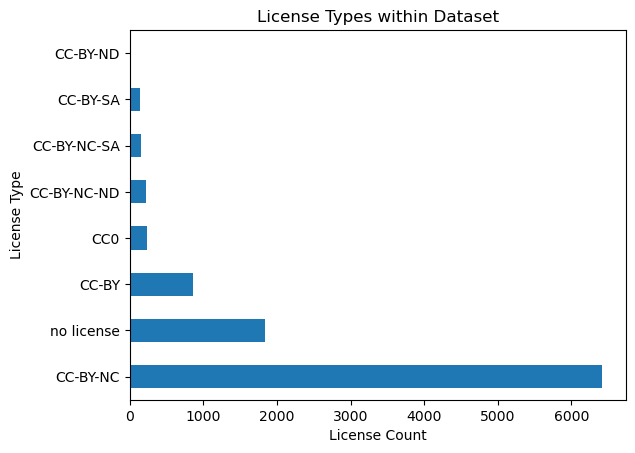

In [30]:
license_count = df['license'].value_counts(sort=True)
license_count.plot.barh()

plt.title('License Types within Dataset')
plt.ylabel('License Type')
plt.xlabel('License Count')
plt.show()

For a full license breakdown and information please consult the global notebook

Remove license from the dataset

In [31]:
df = df.drop(columns=['license'])

### Public Positional Accuracy

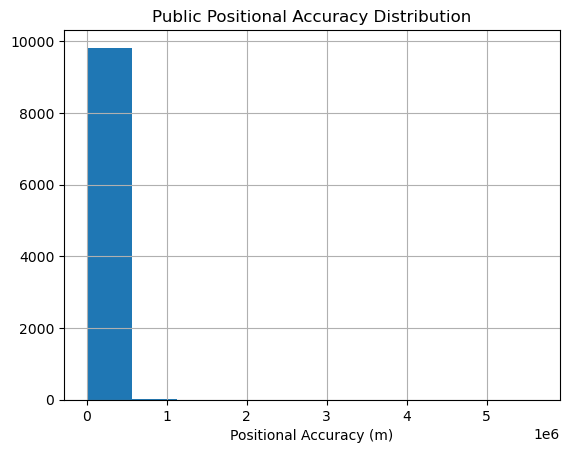

In [32]:
df['public_positional_accuracy'].hist()

plt.title('Public Positional Accuracy Distribution')
plt.xlabel('Positional Accuracy (m)')
plt.show()

The public positional accuracy is comparatively so much higher here as in the global, due to the endangered nature of all Elephant species. As such we will accept accuracy values up to 40000m, and assume that environmental conditions will vary little, as the obscuring of the location is a random point set to within a 10km^2 centered at the original location

In [33]:
df = df[df['public_positional_accuracy'] <= 40000]

In [34]:
df.shape

(9196, 61)

Dropping accuracies greater than 40000 enables us to retain 90% of the dataset.

In [35]:
df = df.drop(columns=['public_positional_accuracy'])

### Species Distributions

In [36]:
species_counts = df['taxon_species_name'].value_counts()
print(species_counts.head(5))

Loxodonta africana    7423
Elephas maximus       1585
Loxodonta cyclotis     188
Name: taxon_species_name, dtype: int64


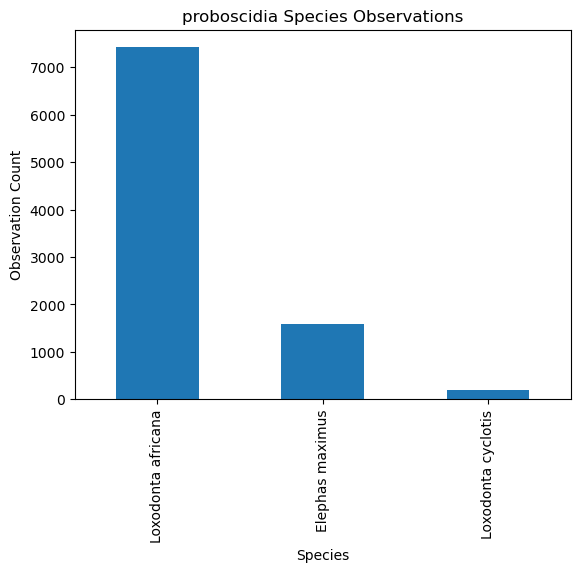

In [37]:
species_counts.plot(kind='bar')

plt.title('proboscidia Species Observations')
plt.xlabel('Species')
plt.ylabel('Observation Count')
plt.show()

### Scientific Name Distributions (Sub-species)

In [38]:
scientific_counts = df['scientific_name'].value_counts()
print(scientific_counts.head(10))

Loxodonta africana            7210
Elephas maximus indicus        745
Elephas maximus maximus        470
Loxodonta                      213
Elephas maximus                205
Loxodonta cyclotis             188
Elephas maximus borneensis     151
Elephas maximus sumatranus      14
Name: scientific_name, dtype: int64


The scientific name, here has 3 types
1. Single word name: This refers to the Genus of the species
2. Two word name: Binomian nomenclature is the same as the species name
3. Three word name: This is trinomial nomenclature and indicates sub-species. In this case sub-species of the Asian Elephant

In [39]:
def sub_species_detection(x):
    name_count = len(x['scientific_name'].split())
    if name_count >= 3:
        x['sub_species'] = x['scientific_name']
    return x

In [40]:
df = df.apply(lambda x: sub_species_detection(x), axis=1)

In [41]:
sub_species = df[df['sub_species'].notnull()]

Sub-species is now captured, so scientific name can be removed

In [42]:
df = df.drop(columns=['scientific_name'])

In [43]:
sub_species = sub_species['sub_species'].value_counts()

In [44]:
sub_species.head()

Elephas maximus indicus       745
Elephas maximus maximus       470
Elephas maximus borneensis    151
Elephas maximus sumatranus     14
Name: sub_species, dtype: int64

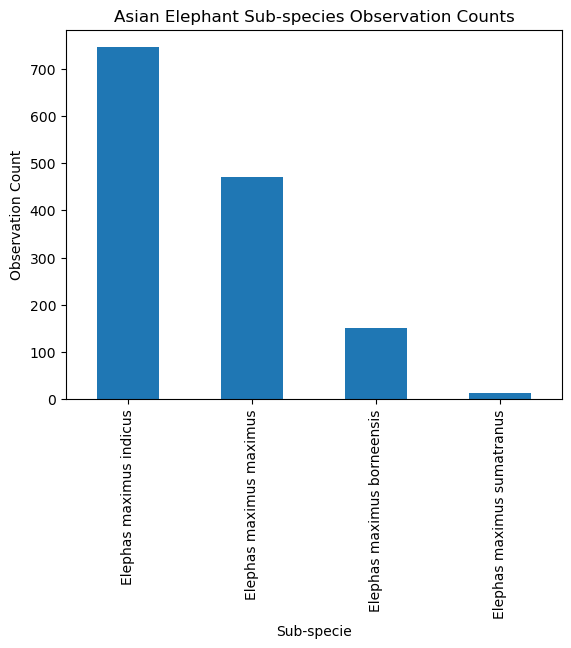

In [45]:
sub_species.plot(kind='bar')

plt.xlabel('Sub-specie')
plt.ylabel('Observation Count')
plt.title('Asian Elephant Sub-species Observation Counts')
plt.show()

## Geographical Distribution

### Species Distribution

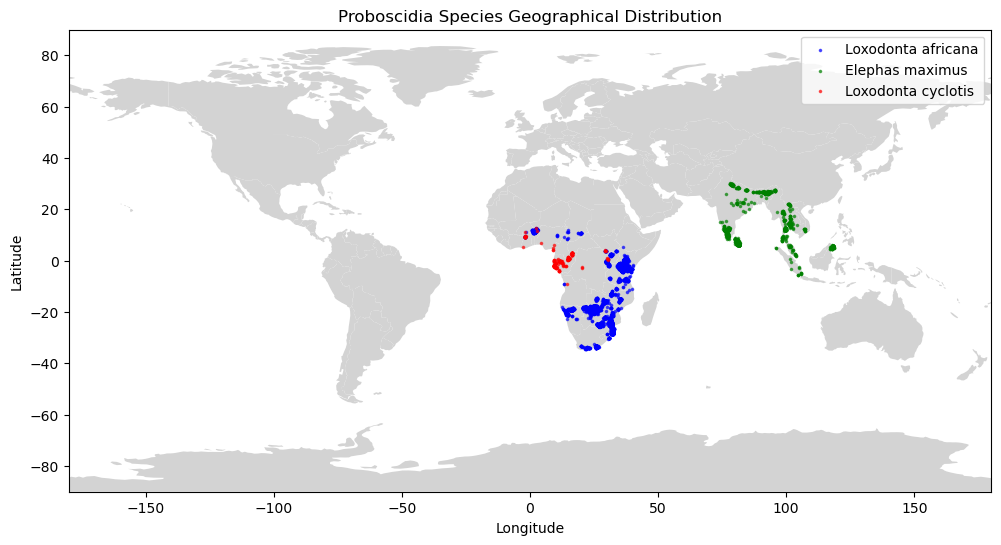

In [46]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


colours = {'Loxodonta africana': 'tab:blue', 
           'Elephas maximus': 'tab:green',
          'Loxodonta cyclotis': 'tab:red'}

# Africana Species
africana_df = df[df['taxon_species_name'] == 'Loxodonta africana']
africana_x = africana_df['longitude']
africana_y = africana_df['latitude']

# Maximus Species
maximus_df = df[df['taxon_species_name'] == 'Elephas maximus']
maximus_x = maximus_df['longitude']
maximus_y = maximus_df['latitude']

#Cyclotis
cyc_df = df[df['taxon_species_name'] == 'Loxodonta cyclotis']
cyc_x = cyc_df['longitude']
cyc_y = cyc_df['latitude']

# Scatter plots
scatter = plt.scatter(africana_x, africana_y, s=2.5, alpha=0.6, c='blue', label='Loxodonta africana')
scatter = plt.scatter(maximus_x, maximus_y, s=2.5, alpha=0.6, c='green', label='Elephas maximus')
scatter = plt.scatter(cyc_x, cyc_y, s=2.5, alpha=0.6, c='red', label='Loxodonta cyclotis')


# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Proboscidia Species Geographical Distribution")
plt.legend()

plt.show()

### Sub-species Distribution

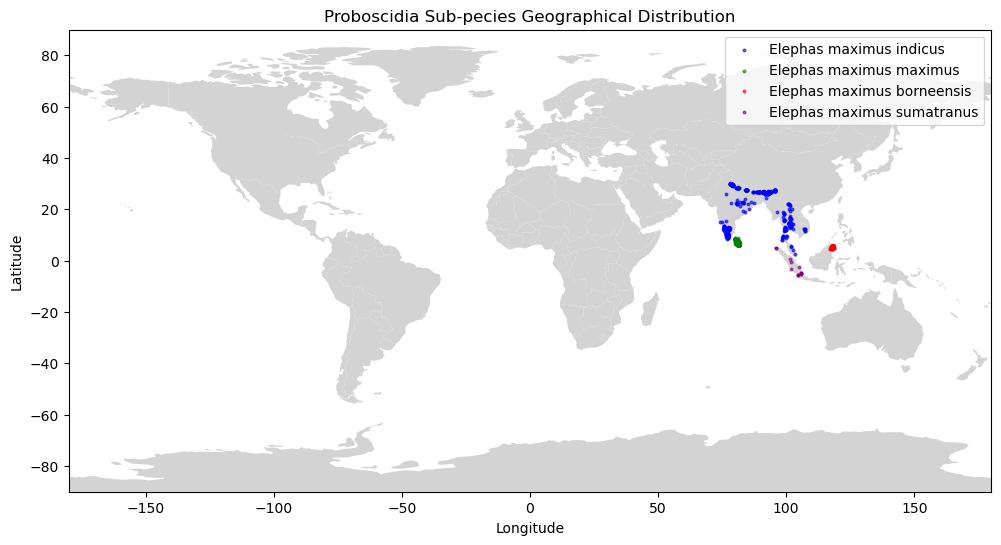

In [47]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


colours = {'Loxodonta africana': 'tab:blue', 
           'Elephas maximus': 'tab:green',
          'Loxodonta cyclotis': 'tab:red'}

# Indicus
indicus_df = df[df['sub_species'] == 'Elephas maximus indicus']
indicus_x = indicus_df['longitude']
indicus_y = indicus_df['latitude']

# Maximus 
maximus_df = df[df['sub_species'] == 'Elephas maximus maximus']
maximus_x = maximus_df['longitude']
maximus_y = maximus_df['latitude']

# Borneensis
born_df = df[df['sub_species'] == 'Elephas maximus borneensis']
born_x = born_df['longitude']
born_y = born_df['latitude']

# Sumatranus
sum_df = df[df['sub_species'] == 'Elephas maximus sumatranus']
sum_x = sum_df['longitude']
sum_y = sum_df['latitude']

# Scatter plots
scatter = plt.scatter(indicus_x, indicus_y, s=3.5, alpha=0.6, c='blue', label='Elephas maximus indicus')
scatter = plt.scatter(maximus_x, maximus_y, s=3.5, alpha=0.6, c='green', label='Elephas maximus maximus')
scatter = plt.scatter(born_x, born_y, s=3.5, alpha=0.6, c='red', label='Elephas maximus borneensis')
scatter = plt.scatter(sum_x, sum_y, s=3.5, alpha=0.6, c='purple', label='Elephas maximus sumatranus')


# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Proboscidia Sub-pecies Geographical Distribution")
plt.legend()

plt.show()

### Coordinate Feature

Similar to the coordinate feature generation in the global notebook, a K-means algorithm will be utilized in order to generate centroids, or hotspots for each species. 

In [48]:
location_df = df[['latitude', 'longitude']]

In [49]:
location_matrix = location_df.to_numpy()
location_matrix

array([[-17.94644857,  25.10001507],
       [-18.42256963,  24.01211018],
       [-19.19652851,  23.83784228],
       ...,
       [-24.77209491,  31.66297288],
       [-19.1167756 ,  26.75366203],
       [-15.63744797,  29.38621327]])

In [50]:
def calculate_optimal_k(data, k_max, interval, k_init):
    ssw = []
    
    k = k_init
    while k <= k_max:
        k_means = KMeans(n_clusters=k,  n_init=10).fit(data)
        centroids = k_means.cluster_centers_
        predicted_clusters = k_means.predict(data)
        sse = 0
        
        # Calculate distance from each point to cluster center. This is accumulated to be the SSW
        for locat in range(len(data)):
            centroid = centroids[predicted_clusters[locat]]
            sse += (data[locat, 0] - centroid[0]) ** 2 + (data[locat, 1] - centroid[1]) ** 2
            
        ssw.append(sse)
        
        k += interval
    return ssw

In [51]:
k_max = 150
interval = 2
k_init = 2

kmeans_ssw = calculate_optimal_k(location_matrix, k_max, interval, k_init)

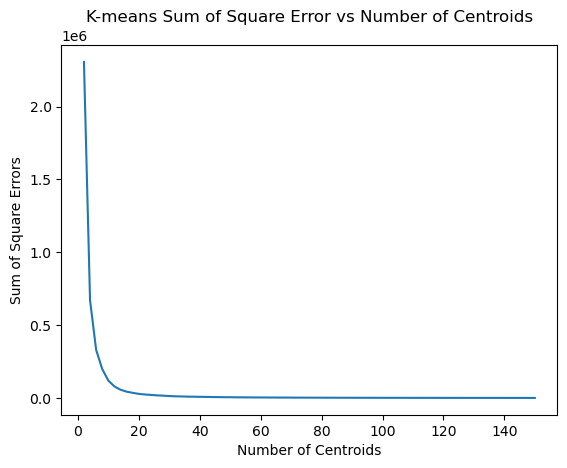

In [52]:
plt.plot(range(k_init, k_max + interval, interval), kmeans_ssw)

plt.xlabel('Number of Centroids')
plt.ylabel('Sum of Square Errors')
plt.title('K-means Sum of Square Error vs Number of Centroids')
plt.show()

In [53]:
k_means = KMeans(n_clusters=20, n_init=10)
k_means.fit(location_matrix)
clusters = k_means.cluster_centers_

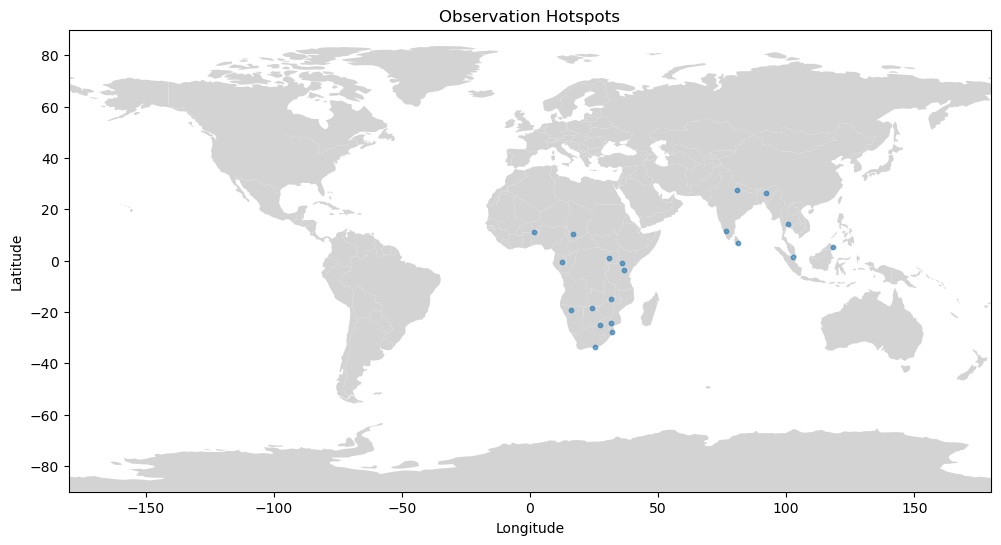

In [54]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

latitude = clusters[:, 0]
longitude = clusters[:, 1]

plt.scatter(longitude, latitude, s=10, alpha=0.6)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title("Observation Hotspots")

plt.show()

The elbow rule approximates the number of centroids to be approximately 16, however reviewing the species distribution, the number of clusters set to 20, produces a map that identifies all hotspots.

In [55]:
df['location_cluster'] = k_means.predict(df[['latitude', 'longitude']])

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [56]:
df['location_cluster'].head()

id
16344     7
17097     7
17099     7
17110    16
17119    16
Name: location_cluster, dtype: int32

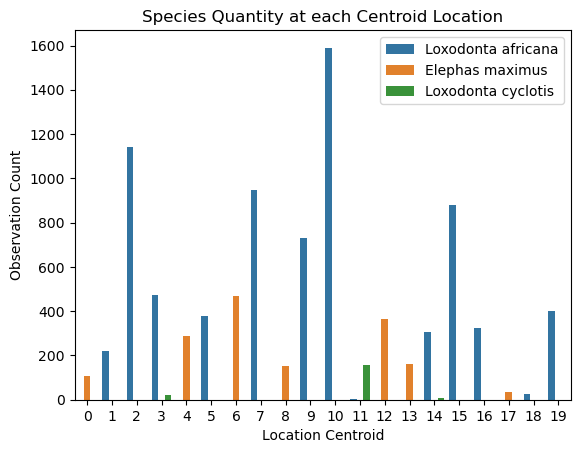

In [57]:
sns.countplot(data=df, x='location_cluster', hue='taxon_species_name')

plt.title('Species Quantity at each Centroid Location')
plt.xlabel('Location Centroid')
plt.ylabel('Observation Count')
plt.legend()
plt.show()

### Terrestrial vs Aquatic Feature

The dataset is assumed to all be land-based due to the nature of the taxonic class. Due to the location of observations on islands where course coordinates may mistakenly place a location within the ocean during obfuscation, all land values are set to positive. 

In [58]:
def land_mask(x):
    latitude = x['latitude']
    longitude = x['longitude']
    x['land'] = int(globe.is_land(latitude, longitude))
    return x

In [59]:
df = df.apply(lambda x: land_mask(x), axis=1)

In [60]:
df['land'].value_counts()

1    9022
0     174
Name: land, dtype: int64

As discussed, all land values will be initalized to 1, due to the island nature of some nightings.

In [61]:
df['land'] = 1

## Skipped Features

Examples of how other features, such as Month, Hour, Night/Day, amongst others can be viewed in the global notebook. 

Next annual weather conditions per species will be compared, in order to build a 'gut-feeling' of if a classification model would have the capacity to differentiate species using this additional meta information

## Elevation

In [62]:
def elevation_clean(x):  # If observation is terrestrial, 0.0m elevation requires modification 
    land = x['land']
    elevation = x['elevation']
    if land == 1 and elevation == 0:
        x['elevation'] = np.nan
    return x

In [63]:
df = df.apply(lambda x: elevation_clean(x), axis=1)

For more information on the process below, please review the global notebook. 

In [64]:
df['elevation'] = df['elevation'].fillna(df.groupby('taxon_species_name')['elevation'].transform('mean'))

In [65]:
errors = df[(df['elevation'] == 0) & (df['land'] == 1)]

In [66]:
assert errors.shape[0] == 0

## Annual Weather Conditions per Species

### Prerequisite Date and Time Transformations

#### DateTime observed_on Feature

In [67]:
df['observed_on'].isnull().any()

False

In [68]:
df['observed_on'] = pd.to_datetime(df['observed_on'],
                                  format="%Y-%m-%d %H:%M:%S%z",
                                  utc=True)

#### Month Feature

In [69]:
df['month'] = df['observed_on'].dt.month

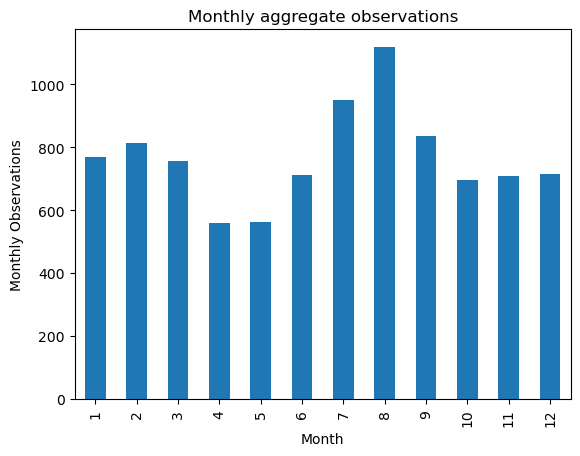

In [70]:
df['month'].value_counts().sort_index().plot.bar()

plt.title('Monthly aggregate observations')
plt.xlabel('Month')
plt.ylabel('Monthly Observations')
plt.show()

#### Hour of Observation

In [71]:
df['hour'] = df.apply(lambda x: x['observed_on'].astimezone(pytz.timezone(x['time_zone'])).hour, axis=1)

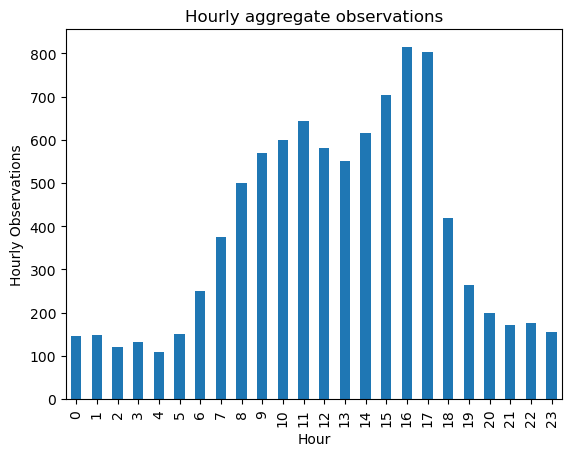

In [72]:
df['hour'].value_counts().sort_index().plot.bar()

plt.title('Hourly aggregate observations')
plt.xlabel('Hour')
plt.ylabel('Hourly Observations')
plt.show()

#### Dark/ Light Calculation

In [73]:
df['sunrise'] = pd.to_datetime(df['sunrise'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')
df['sunset'] = pd.to_datetime(df['sunset'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')

df = df.dropna(subset=['sunrise', 'sunset'])

In [74]:
def localize_sunrise_sunset(x):
    timezone = pytz.timezone(x['time_zone'])
    x['sunrise'] = x['sunrise'].replace(tzinfo=timezone)
    x['sunset'] = x['sunset'].replace(tzinfo=timezone)
    return x

In [75]:
df = df.apply(lambda x: localize_sunrise_sunset(x), axis=1)

In [76]:
def dark_light_calc(x):
    timezone = pytz.timezone(x['time_zone'])
    sunrise_utc = x['sunrise']
    sunset_utc = x['sunset']
    
    observ_time = x['observed_on'].replace(tzinfo=pytz.utc)
    observ_time = x['observed_on'].astimezone(timezone)
    
    x['light'] = int(sunrise_utc <= observ_time <= sunset_utc)
    return x   

In [77]:
df = df.apply(lambda x: dark_light_calc(x), axis=1)

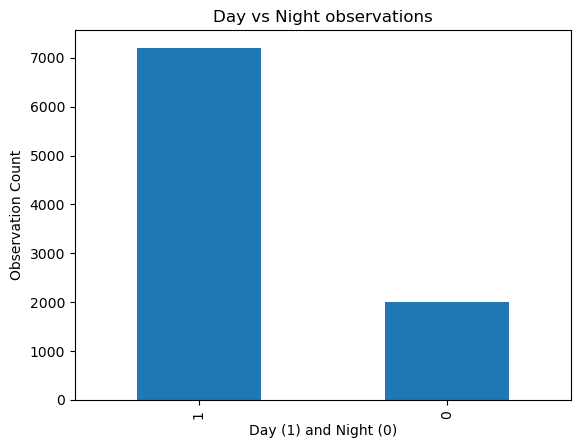

In [78]:
df['light'].value_counts().plot.bar()

plt.title('Day vs Night observations')
plt.xlabel('Day (1) and Night (0)')
plt.ylabel('Observation Count')
plt.show()

Create a method that encapsulates the day/night calculation 

In [79]:
def day_night_calculation(df):
    # Convert to datetime objects. Remove NaT values from resulting transformation
    df['sunrise'] = pd.to_datetime(df['sunrise'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')
    df['sunset'] = pd.to_datetime(df['sunset'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')
    df = df.dropna(subset=['sunrise', 'sunset'])
    
    # Localize sunrise and sunset times to be timezone aware
    df = df.apply(lambda x: localize_sunrise_sunset(x), axis=1)
    
    # Dark/ light calc based on sunrise and sunset times
    df = df.apply(lambda x: dark_light_calc(x), axis=1)
    
    df = df.drop(columns=['sunrise', 'sunset'])
    
    return df

#### Hemisphere

In [80]:
df['hemisphere'] = (df['latitude'] >= 0).astype(int)

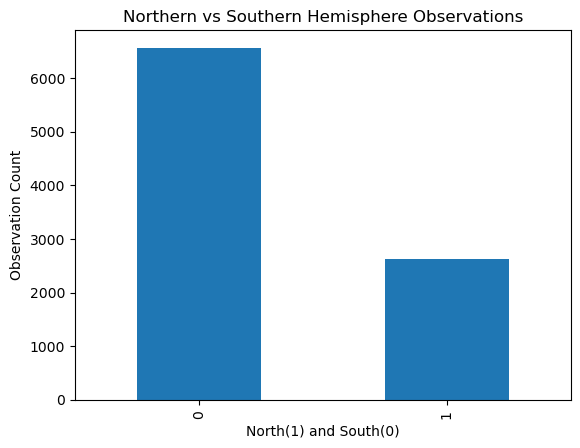

In [81]:
df['hemisphere'].value_counts().plot.bar()

plt.title('Northern vs Southern Hemisphere Observations')
plt.xlabel('North(1) and South(0)')
plt.ylabel('Observation Count')
plt.show()

#### Season

In [82]:
def season_calc(x):
    hemisphere = x['hemisphere']
    month = x['month']
    season = 0
    if hemisphere == 1: # Northern hemisphere
        winter, spring, summer, autumn = [12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]
        seasons = [winter, spring, summer, autumn]
        season = north_south_calc(month, seasons)
    else:
        winter, spring, summer, autumn = [6, 7, 8], [9, 10, 11], [12, 1, 2], [3, 4, 5]
        seasons = [winter, spring, summer, autumn]
        season = north_south_calc(month, seasons)
    
    x['season'] = season
    return x
        
def north_south_calc(month: int, seasons: list):
    seasons_dict = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
    season_id = 0
    for i in range(len(seasons)):
        if month in seasons[i]:
            season_id = i
    return seasons_dict[season_id]

In [83]:
df = df.apply(lambda x: season_calc(x), axis=1)

In [84]:
def ohe_season(df):
    cats = ['Winter', 'Spring', 'Summer', 'Autumn']
    cat_type = CategoricalDtype(categories=cats)
    
    df['season'] = df['season'].astype(cat_type)
    
    df = pd.get_dummies(df,
                        prefix='szn',
                        columns=['season'], 
                        drop_first=True)
    return df

In [85]:
df = ohe_season(df)
df.filter(regex='szn').head(10)

,szn_Spring,szn_Summer,szn_Autumn
id,,,
16344,1,0,0
17097,1,0,0
17099,1,0,0
17110,1,0,0
17119,1,0,0
17262,1,0,0
17267,1,0,0
17954,1,0,0
17964,1,0,0


### Annual Species Weather Distribution Comparisons

In [86]:
weather_df = df.groupby(by=['taxon_species_name', 
                        df.observed_on.dt.month]).agg({'elevation': 'mean',
                                                                    'temperature_2m': 'mean',
                                                                    'relativehumidity_2m': 'mean', 
                                                                    'precipitation': 'mean'})

#### Elevation

In [87]:
elevation_df = weather_df['elevation'].to_frame()
elevation_df = elevation_df.reset_index(level=['observed_on'])
elevation_df = elevation_df.pivot(columns='observed_on', values='elevation')
elevation_df.head()

observed_on,1,2,3,4,5,6,7,8,9,10,11,12
taxon_species_name,,,,,,,,,,,,
Elephas maximus,458.736444,396.954337,309.972345,382.576490,491.512167,336.875841,356.490470,399.137765,376.661156,464.358590,445.993233,457.057617
Loxodonta africana,735.343271,732.961326,636.082227,691.360743,726.212324,782.390785,806.227124,791.821318,800.022466,766.032077,751.003686,728.659076
Loxodonta cyclotis,453.766071,242.589286,313.851190,277.270089,375.962302,415.272727,303.684211,345.872449,399.571429,168.380102,340.572143,254.215179


Fill in missing months of elevation data with mean of each species

In [88]:
elevation_df = elevation_df.apply(lambda row: row.fillna(row.mean()), axis=1)

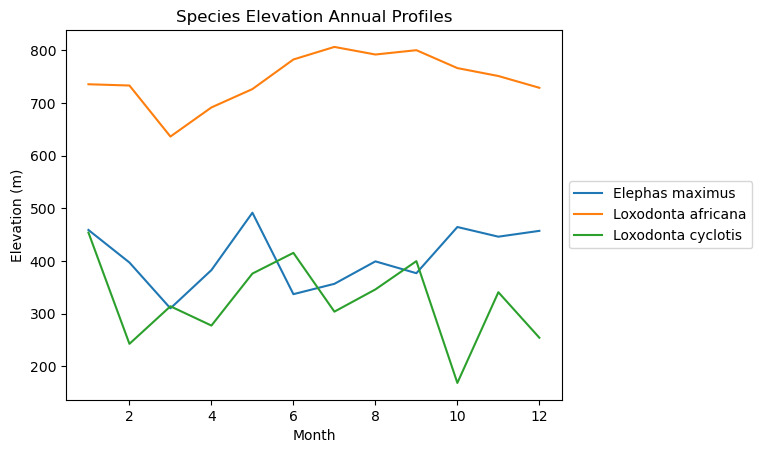

In [89]:
elevation_df.T.plot.line()

plt.title('Species Elevation Annual Profiles')
plt.xlabel('Month')
plt.ylabel('Elevation (m)')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

#### Temperature

In [90]:
temperature_2m_df = weather_df['temperature_2m'].to_frame()
temperature_2m_df = temperature_2m_df.reset_index(level=['observed_on'])
temperature_2m_df = temperature_2m_df.pivot(columns='observed_on', values='temperature_2m')
temperature_2m_df = temperature_2m_df.apply(lambda row: row.fillna(row.mean()), axis=1)

In [91]:
temperature_2m_df.head()

observed_on,1,2,3,4,5,6,7,8,9,10,11,12
taxon_species_name,,,,,,,,,,,,
Elephas maximus,23.676757,24.721557,26.446890,27.86259,25.828571,27.065517,26.722449,26.151818,26.396330,24.472632,24.119200,23.252542
Loxodonta africana,25.836174,26.340221,27.212801,26.19505,23.228145,21.230556,21.250542,23.147315,24.984136,25.450510,25.152236,25.735645
Loxodonta cyclotis,24.710000,27.084615,25.433333,28.01875,26.966667,26.863636,24.647368,25.090476,26.328571,26.435714,26.028000,26.470000


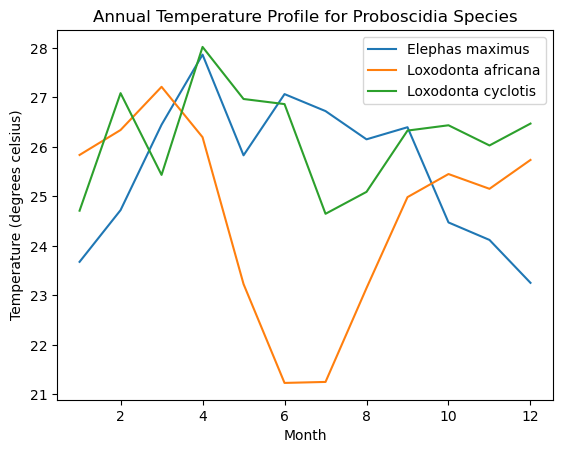

In [92]:
temperature_2m_df.T.plot.line()

plt.title('Annual Temperature Profile for Proboscidia Species')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees celsius)')
plt.legend()
plt.show()

#### Relative Humidity

In [93]:
humidity_2m_df = weather_df['relativehumidity_2m'].to_frame()
humidity_2m_df = humidity_2m_df.reset_index(level=['observed_on'])
humidity_2m_df = humidity_2m_df.pivot(columns='observed_on', values='relativehumidity_2m')
humidity_2m_df = humidity_2m_df.apply(lambda row: row.fillna(row.mean()), axis=1)

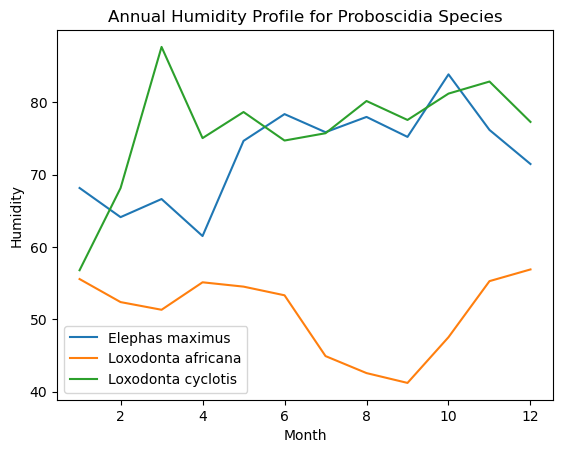

In [94]:
humidity_2m_df.T.plot.line()

plt.title('Annual Humidity Profile for Proboscidia Species')
plt.xlabel('Month')
plt.ylabel('Humidity')
plt.legend()
plt.show()

#### Precipitation

In [95]:
precipitation_df = weather_df['precipitation'].to_frame()
precipitation_df = precipitation_df.reset_index(level=['observed_on'])
precipitation_df = precipitation_df.pivot(columns='observed_on', values='precipitation')
precipitation_df = precipitation_df.apply(lambda row: row.fillna(row.mean()), axis=1)

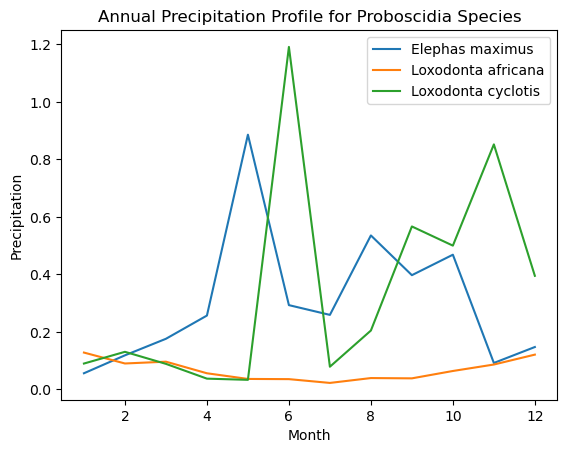

In [96]:
precipitation_df.T.plot.line()

plt.title('Annual Precipitation Profile for Proboscidia Species')
plt.xlabel('Month')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

## Pipeline

In [99]:
def aggregate_data() -> pd.DataFrame:
    proboscidia_df = pd.read_csv(file_path + 'proboscidia_train.csv', index_col=0)
    meta_df = pd.read_csv(file_path + 'proboscidia_meta.csv', index_col=0) 
    
    proboscidia_df = proboscidia_df.drop(columns=['observed_on', 'local_time_observed_at', 'positional_accuracy'])
    meta_df = meta_df.drop(columns=['lat', 'long', 'time'])
    
    df = pd.merge(proboscidia_df, meta_df, how='inner', left_index=True, right_index=True)
    return df

def pipeline(df, k_means, taxon_target):
    ## CLEAN UP##
    
    # Remove non-essential columns
    df = df.drop(columns=['geoprivacy', 'taxon_geoprivacy', 'taxon_id', 'license', 'image_url'])
    
    # Remove null species names
    df = df.dropna(subset=['taxon_species_name'])
    
    # Drop null positional accuracies
    df = df.dropna(subset=['public_positional_accuracy'])
    
    # Species name fix
    df.loc[df['taxon_species_name'].isnull(), 'taxon_species_name'] = 'Loxodonta africana'
    df = df[df['common_name'] != 'Savannah × Forest Elephant']
    
    # Drop null positional accuracies
    df = df.dropna(subset=['public_positional_accuracy'])
    
    # Positional Accuracy Restriction
    df = df[df['public_positional_accuracy'] <= 40000]
    df = df.drop(columns=['public_positional_accuracy'])

    
    ## TRANSFORM ##
    
    # Generate sub-species and drop scientific name
    df = df.apply(lambda x: sub_species_detection(x), axis=1)
    df = df.drop(columns=['scientific_name'])
    
    # Location Centroid Feature
    df['location_cluster'] = k_means.predict(df[['latitude', 'longitude']])
    
    # Terrestrial vs Land Feature
    df['land'] = 1
    
    # Elevation Logical Path, dependent on land
    df = df.apply(lambda x: elevation_clean(x), axis=1)
    df['elevation'] = df['elevation'].fillna(df.groupby('taxon_species_name')['elevation'].transform('mean'))
    
    # Northern and Southern Hemisphere OHE
    df['hemisphere'] = (df['latitude'] >= 0).astype(int)
    df = df.drop(columns=['latitude', 'longitude'])
    
    # Datetime Transformation
    df['observed_on'] = pd.to_datetime(df['observed_on'],
                                  format="%Y-%m-%d %H:%M:%S%z",
                                  utc=True)
    
    # Month Feature
    df['month'] = df['observed_on'].dt.month
    
    # Hour Feature
    df['hour'] = df.apply(lambda x: x['observed_on'].astimezone(pytz.timezone(x['time_zone'])).hour, axis=1)
    
    # Day/Night Feature
    df = day_night_calculation(df)
    
    # Season Feature
    df = df.apply(lambda x: season_calc(x), axis=1)
    df = ohe_season(df)
    
    # Drop observed on column as date & time transformations are complete
    df = df.drop(columns=['observed_on', 'time_zone'])
    
    ## SAVE ##
    df.to_csv('local_data_cache/final_data.csv')
    
    ## TRAIN & TEST DATA
    # Retrieve labels
    taxon_y = df[taxon_target]
    
    # Sub-specie contains null values, if selected as target taxon. Remove
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
        
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                   'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                   'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=35)
    return X_train, X_test, y_train, y_test

In [100]:
df_final = aggregate_data()

In [101]:
X_train, X_test, y_train, y_test = pipeline(df_final, k_means, 'taxon_species_name')

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Preview train and test data

In [102]:
X_train.head()

,apparent_temperature,apparent_temperature_max,apparent_temperature_min,cloudcover,cloudcover_high,cloudcover_low,cloudcover_mid,dewpoint_2m,diffuse_radiation,direct_radiation,elevation,et0_fao_evapotranspiration_daily,et0_fao_evapotranspiration_hourly,precipitation,precipitation_hours,precipitation_sum,rain,rain_sum,relativehumidity_2m,shortwave_radiation,shortwave_radiation_sum,snowfall,snowfall_sum,soil_moisture_0_to_7cm,soil_moisture_28_to_100cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_28_to_100cm,soil_temperature_7_to_28cm,surface_pressure,temperature_2m,temperature_2m_max,temperature_2m_min,vapor_pressure_deficit,weathercode_daily,weathercode_hourly,winddirection_100m,winddirection_10m,winddirection_10m_dominant,windgusts_10m,windgusts_10m_max,windspeed_100m,windspeed_10m,windspeed_10m_max,location_cluster,land,hemisphere,month,hour,light,szn_Spring,szn_Summer,szn_Autumn
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10369512,19.7,20.6,3.0,0.0,0.0,0.0,0.0,-2.8,91.0,330.0,986.0,4.29,0.35,0.0,0.0,0.0,0.0,0.0,17.0,421.0,17.64,0.0,0.0,0.173,0.240,0.221,25.7,17.4,17.8,913.7,23.9,24.3,6.6,2.47,0,0,41.0,41.0,34.0,29.5,33.5,15.8,12.0,14.1,1,1,0,8,16,1,0,0,0
109210718,23.5,24.5,8.4,0.0,0.0,0.0,0.0,2.5,121.0,667.0,1061.0,5.61,0.62,0.0,0.0,0.0,0.0,0.0,21.0,788.0,19.75,0.0,0.0,0.259,0.288,0.300,26.8,17.7,19.0,897.0,26.4,28.9,10.8,2.71,0,0,306.0,307.0,271.0,36.0,41.4,20.6,16.2,20.3,1,1,0,8,12,1,0,0,0
109393863,34.0,38.6,27.0,21.0,44.0,4.0,7.0,24.0,209.0,265.0,283.0,4.20,0.35,0.5,15.0,18.2,0.5,18.2,77.0,474.0,20.37,0.0,0.0,0.482,0.429,0.465,29.0,26.6,27.1,969.3,28.4,30.9,22.7,0.88,63,53,200.0,193.0,171.0,20.2,20.9,4.2,3.3,8.2,11,1,0,3,16,1,0,0,1
68519027,23.7,34.8,22.4,44.0,92.0,8.0,15.0,19.8,102.0,127.0,1000.0,4.93,0.14,0.2,16.0,10.9,0.2,10.9,88.0,229.0,24.42,0.0,0.0,0.373,0.168,0.233,24.1,27.1,26.1,903.7,21.8,29.3,20.2,0.30,63,51,31.0,32.0,23.0,28.1,37.1,18.4,13.1,15.9,7,1,0,12,8,1,0,1,0
130530642,24.9,27.4,16.5,0.0,0.0,0.0,0.0,14.4,44.0,88.0,253.0,3.68,0.13,0.0,0.0,0.0,0.0,0.0,52.0,132.0,18.20,0.0,0.0,0.258,0.378,0.315,26.0,23.1,23.2,981.6,25.0,27.3,16.0,1.52,1,0,52.0,58.0,6.0,25.2,29.5,20.5,10.2,12.7,19,1,0,4,17,1,0,0,1


In [104]:
y_train.head()

id
10369512     Loxodonta africana
109210718    Loxodonta africana
109393863    Loxodonta cyclotis
68519027     Loxodonta africana
130530642    Loxodonta africana
Name: taxon_species_name, dtype: object

## Modelling

In [105]:
def write_scores_to_file(mean_scores: list, depth_range: list, filename: str):
    df = pd.DataFrame({'depth': depth_range, 'mean_scores': mean_scores})
    df.to_csv('local_data_cache/' + filename, index=False)

### Decision Tree

Two scores types are used in the below cross-validation testing, `balanced_accuracy` and `accuracy`. Accuracy will contain biase due to the unbalanced dataset, however `balanced_accuracy` aims to rectify this and provide a measure of the actual accuracy against all classes.

In order to generate both accuracy measures, please alter:
1. `scoring='balanced_accuracy'` or `scoring='accuracy'`
2. Alter the file name in the calling of the `write_scores_to_file` method between `elephant_species_dt_balanced_accuracy.csv` or `elephant_species_dt_accuracy`

In [106]:
depth_limit = len(X_train.columns)
depth_range = range(1, depth_limit, 1)
scores = []

In [107]:
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    score = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            n_jobs=-1,
                            scoring='balanced_accuracy')

    # Average the scores
    score_mean = np.mean(score)
    scores.append(score_mean)

write_scores_to_file(scores, [*depth_range], 'elephant_species_dt_balanced_accuracy.csv')

In [108]:
dt_accuracy = pd.read_csv('local_data_cache/elephant_species_dt_accuracy.csv')
dt_balanced_accuracy = pd.read_csv('local_data_cache/elephant_species_dt_balanced_accuracy.csv')

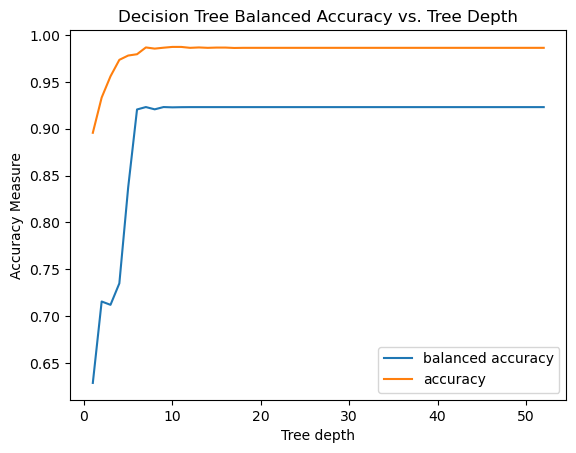

In [109]:
plt.plot(dt_balanced_accuracy['depth'], dt_balanced_accuracy['mean_scores'], label='balanced accuracy')
plt.plot(dt_accuracy['depth'], dt_accuracy['mean_scores'], label='accuracy')

plt.title('Decision Tree Balanced Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy Measure')
plt.legend()
plt.show()

### Random Forest

In [110]:
depth_limit = len(X_train.columns)
depth_range = range(1, depth_limit, 1)
scores = []

In [111]:
for depth in depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    score = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            n_jobs=-1,
                            scoring='balanced_accuracy')

    # Average the scores
    score_mean = np.mean(score)
    scores.append(score_mean)

write_scores_to_file(scores, [*depth_range], 'elephant_species_rf_balanced_accuracy.csv')

In [112]:
rf_accuracy = pd.read_csv('local_data_cache/elephant_species_rf_accuracy.csv')
rf_balanced_accuracy = pd.read_csv('local_data_cache/elephant_species_rf_balanced_accuracy.csv')

[]

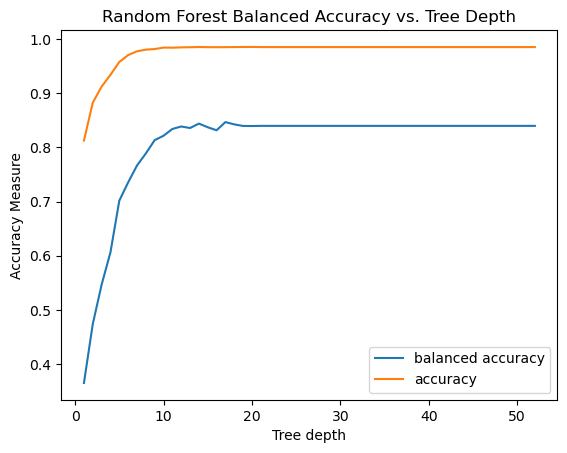

In [113]:
plt.plot(rf_balanced_accuracy['depth'], rf_balanced_accuracy['mean_scores'], label='balanced accuracy')
plt.plot(rf_accuracy['depth'], rf_accuracy['mean_scores'], label='accuracy')

plt.title('Random Forest Balanced Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy Measure')
plt.legend()
plt.plot()

### Neural Network

Augment the training and test sets to be normalized, and contain dummy columns for catagorical variables including cluster_locations, month, and time.

In [114]:
def ohe_month(df):
    cats = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    cat_type = CategoricalDtype(categories=cats)
    
    df['season'] = df['season'].astype(cat_type)
    
    df = pd.get_dummies(df,
                        prefix='szn',
                        columns=['season'], 
                        drop_first=True)
    return df

In [115]:
def pipeline(df, k_means, taxon_target):
    ## CLEAN UP##
    
    # Remove non-essential columns
    df = df.drop(columns=['geoprivacy', 'taxon_geoprivacy', 'taxon_id', 'license', 'image_url',
                         'weathercode_daily', 'weathercode_hourly'])
    
    # Species name fix
    df.loc[df['taxon_species_name'].isnull(), 'taxon_species_name'] = 'Loxodonta africana'
    df = df[df['common_name'] != 'Savannah × Forest Elephant']
    
    # Drop null positional accuracies
    df = df.dropna(subset=['public_positional_accuracy'])
    
    # Positional Accuracy Restriction
    df = df[df['public_positional_accuracy'] <= 40000]
    df = df.drop(columns=['public_positional_accuracy'])

    
    ## TRANSFORM ##
    
    # Generate sub-species and drop scientific name
    df = df.apply(lambda x: sub_species_detection(x), axis=1)
    df = df.drop(columns=['scientific_name'])
    
    # Remove species with less than 10 observations
    df = df[df.groupby(taxon_target).common_name.transform('count') >= 10].copy()
    
    # Location Centroid Feature
    df['location_cluster'] = k_means.predict(df[['latitude', 'longitude']])
    df = pd.get_dummies(df,
                        prefix='loc',
                        columns=['location_cluster'], 
                        drop_first=True)
    
    # Terrestrial vs Land Feature
    df['land'] = 1
    
    # Elevation Logical Path, dependent on land
    df = df.apply(lambda x: elevation_clean(x), axis=1)
    df['elevation'] = df['elevation'].fillna(df.groupby('taxon_species_name')['elevation'].transform('mean'))
    
    # Northern and Southern Hemisphere OHE
    df['hemisphere'] = (df['latitude'] >= 0).astype(int)
    df = df.drop(columns=['latitude', 'longitude'])
    
    # Datetime Transformation
    df['observed_on'] = pd.to_datetime(df['observed_on'],
                                  format="%Y-%m-%d %H:%M:%S%z",
                                  utc=True)
    
    # Month Feature
    df['month'] = df['observed_on'].dt.month
    
    # Hour Feature
    df['hour'] = df.apply(lambda x: x['observed_on'].astimezone(pytz.timezone(x['time_zone'])).hour, axis=1)
    df = pd.get_dummies(df,
                        prefix='hr',
                        columns=['hour'], 
                        drop_first=True)
    
    # Day/Night Feature
    df = day_night_calculation(df)
    
    # Season Feature
    df = df.apply(lambda x: season_calc(x), axis=1)
    df = ohe_season(df)
    
    # Season is depent on month, hence month ohe here
    df = pd.get_dummies(df,
                        prefix='mnth',
                        columns=['month'], 
                        drop_first=True)
    
    # Drop observed on column as date & time transformations are complete
    df = df.drop(columns=['observed_on', 'time_zone'])
    
    ## SAVE ##
    df.to_csv('local_data_cache/final_nn_data.csv')
    
    ## TRAIN & TEST DATA
    # Retrieve labels
    taxon_y = df[taxon_target]
    
    # Sub-specie contains null values, if selected as target taxon. Remove
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
        
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                   'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                   'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    
    # Encode labels
    classes = y.nunique()
    lb = LabelBinarizer()
    lb.fit(y)
    y = lb.transform(y)
    
    # Min-max normalize data
    norm_columns = ['apparent_temperature', 'apparent_temperature_max', 'apparent_temperature_min', 
                    'cloudcover', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'dewpoint_2m', 
                    'diffuse_radiation', 'direct_radiation', 'elevation', 'et0_fao_evapotranspiration_daily', 
                    'et0_fao_evapotranspiration_hourly', 'precipitation', 'precipitation_hours', 
                    'precipitation_sum', 'rain', 'rain_sum', 'relativehumidity_2m', 'shortwave_radiation', 
                    'shortwave_radiation_sum', 'snowfall', 'snowfall_sum', 'soil_moisture_0_to_7cm', 
                    'soil_moisture_28_to_100cm', 'soil_moisture_7_to_28cm', 'soil_temperature_0_to_7cm', 
                    'soil_temperature_28_to_100cm', 'soil_temperature_7_to_28cm', 'surface_pressure', 
                    'temperature_2m', 'temperature_2m_max', 'temperature_2m_min', 'vapor_pressure_deficit', 
                    'winddirection_100m', 'winddirection_10m', 'winddirection_10m_dominant', 
                    'windgusts_10m', 'windgusts_10m_max', 'windspeed_100m', 'windspeed_10m', 
                    'windspeed_10m_max']
    X[norm_columns] = StandardScaler().fit_transform(X[norm_columns])
    
    return X, y, lb, classes

This pipeline results in a feature vector of size 101. This is the neural network input dimension.

In [116]:
df_final = aggregate_data()

In [117]:
X, y, lb, classes = pipeline(df_final, k_means, 'taxon_species_name')

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [118]:
X.head()

,apparent_temperature,apparent_temperature_max,apparent_temperature_min,cloudcover,cloudcover_high,cloudcover_low,cloudcover_mid,dewpoint_2m,diffuse_radiation,direct_radiation,elevation,et0_fao_evapotranspiration_daily,et0_fao_evapotranspiration_hourly,precipitation,precipitation_hours,precipitation_sum,rain,rain_sum,relativehumidity_2m,shortwave_radiation,shortwave_radiation_sum,snowfall,snowfall_sum,soil_moisture_0_to_7cm,soil_moisture_28_to_100cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_28_to_100cm,soil_temperature_7_to_28cm,surface_pressure,temperature_2m,temperature_2m_max,temperature_2m_min,vapor_pressure_deficit,winddirection_100m,winddirection_10m,winddirection_10m_dominant,windgusts_10m,windgusts_10m_max,windspeed_100m,windspeed_10m,windspeed_10m_max,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13,loc_14,loc_15,loc_16,loc_17,loc_18,loc_19,land,hemisphere,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,light,szn_Spring,szn_Summer,szn_Autumn,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16344,-0.096951,0.666094,0.198287,-0.773648,-0.285957,-0.610131,-0.518594,0.489579,-1.226884,-1.022996,0.666091,0.988496,-1.030019,-0.179412,-0.344994,-0.270214,-0.179412,-0.270214,0.374669,-1.195647,1.677244,0.0,0.0,0.125938,-0.856979,-0.430362,-0.243430,0.754110,0.618437,-0.696254,-0.109772,0.304808,0.265850,-0.417609,-0.718752,-0.708272,-0.922245,-0.114849,0.255257,1.423159,0.595199,0.312463,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
17097,0.533108,1.104281,0.888975,0.300628,1.382675,-0.610131,0.483473,0.380050,-1.226884,-1.022996,0.482088,1.336684,-0.942726,-0.179412,-0.344994,-0.270214,-0.179412,-0.270214,-0.302512,-1.195647,1.364705,0.0,0.0,-0.566237,-0.787987,-0.211559,0.474040,0.701765,1.292774,-0.561824,0.599907,1.167151,0.989345,0.295741,-0.698610,-0.678035,-0.974644,-0.952139,-0.039343,0.628856,-0.033160,-0.366220,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
17099,0.098067,1.171694,0.796883,-0.159776,-0.312029,-0.610131,0.791801,0.380050,-1.226884,-1.022996,0.485921,1.050672,-0.899080,-0.179412,0.091427,-0.216981,-0.179412,-0.216981,-0.006245,-1.195647,1.201806,0.0,0.0,-1.350147,-1.744016,-1.657564,0.138203,1.015836,1.742331,-0.536391,0.191841,1.019921,0.882949,-0.080972,-1.121594,-1.151753,-0.974644,0.024700,-0.405053,1.186053,0.697095,-0.151028,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
17110,0.488104,0.969454,1.088507,-0.037002,-0.390246,-0.540242,0.984506,0.955078,-1.226884,-1.022996,-0.296094,0.422691,-1.030019,-0.179412,0.309638,-0.199236,-0.179412,-0.199236,0.586288,-1.195647,0.457396,0.0,0.0,0.059222,-0.817555,-0.839429,0.229795,1.513116,1.292774,0.135761,0.298293,0.809594,0.946787,-0.425624,-0.054063,-0.043051,0.010458,-0.077636,0.367001,1.091211,0.510286,0.097271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
17119,0.293085,0.817774,0.981067,-0.528100,-0.781332,-0.610131,0.367850,0.927696,-1.226884,-1.022996,-0.169591,0.341861,-1.204604,-0.179412,0.309638,-0.199236,-0.179412,-0.199236,0.882555,-1.195647,0.457396,0.0,0.0,0.009186,-0.827411,-0.820403,-0.090777,1.329908,1.067995,0.034030,-0.038804,0.704430,0.840390,-0.690124,0.056718,0.138373,0.010458,-0.477674,0.367001,0.273198,-0.287901,0.097271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


Create the nerual network architecture using a Keras Sequential model.

In [119]:
input_dimension = len(X.columns)

In [120]:
def make_model(input_dimension: int, classes: int) -> keras.Sequential:
    model = keras.Sequential()
    model.add(Dense(input_dimension, input_shape=(input_dimension,), activation='relu'))
    model.add(Dense(80, activation='relu'))

    model.add(Dense(60, activation='relu'))

    model.add(Dense(classes, activation='softmax'))
    return model

In [121]:
folds = 5
kf = KFold(n_splits = folds)

Source for the below cross-validation training setup in Keras: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

In [122]:
fold_histories = dict()
eval_accuracy = []
eval_loss = []
epoch_num = 10
fold_ind = 0

for train_index, test_index in kf.split(X,y):
    # Generate test and validation training sets
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    
    X_val = X.iloc[test_index]
    y_val = y[test_index]
    
    # Create a new model
    model = make_model(input_dimension, classes)

    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[keras.metrics.CategoricalAccuracy()])
    
    # Training History
    history = model.fit(X_train.to_numpy(), y_train, epochs=epoch_num, verbose=0)
    fold_histories[fold_ind] = history
    
    # Validation
    results = model.evaluate(X_val, y_val, verbose=0)
    eval_accuracy = results[1]
    eval_loss = results[0]
    
    fold_ind = fold_ind + 1
    

2023-06-15 19:55:50.873172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 19:55:50.873604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-06-15 19:55:50.873743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-06-15 19:55:51.004754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-06-15 19:55:51.004778: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen som

Visalize the results of training and evaluation

##### Training Categorical Accuracy

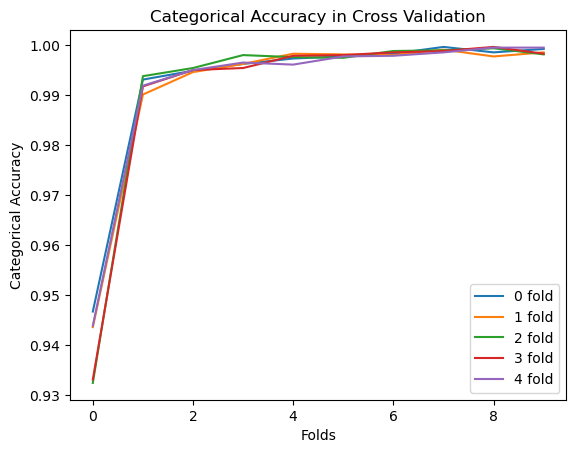

In [123]:
for i in range(folds):
    plt.plot(fold_histories[i].history['categorical_accuracy'], label=(str(i) + ' fold'))

plt.title('Categorical Accuracy in Cross Validation')
plt.xlabel('Folds')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

#### Training Categorical Loss

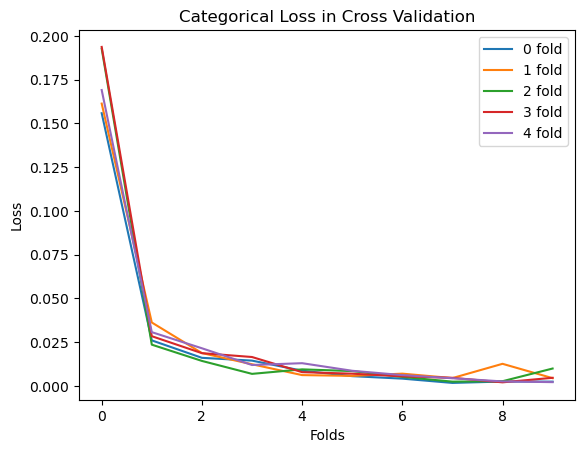

In [124]:
for i in range(folds):
    plt.plot(fold_histories[i].history['loss'], label=(str(i) + ' fold'))

plt.title('Categorical Loss in Cross Validation')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluation Accuracy and Loss

In [125]:
print('Average evaluation accuracy: ', np.mean(eval_accuracy))
print('Average evaluation loss: ', np.mean(eval_loss))

Average evaluation accuracy:  0.9929309487342834
Average evaluation loss:  0.02751627191901207


### Sub-species Training

In [126]:
df_final = aggregate_data()

In [127]:
X, y, lb, classes = pipeline(df_final, k_means, 'sub_species')

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [128]:
X.head()

,apparent_temperature,apparent_temperature_max,apparent_temperature_min,cloudcover,cloudcover_high,cloudcover_low,cloudcover_mid,dewpoint_2m,diffuse_radiation,direct_radiation,elevation,et0_fao_evapotranspiration_daily,et0_fao_evapotranspiration_hourly,precipitation,precipitation_hours,precipitation_sum,rain,rain_sum,relativehumidity_2m,shortwave_radiation,shortwave_radiation_sum,snowfall,snowfall_sum,soil_moisture_0_to_7cm,soil_moisture_28_to_100cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_28_to_100cm,soil_temperature_7_to_28cm,surface_pressure,temperature_2m,temperature_2m_max,temperature_2m_min,vapor_pressure_deficit,winddirection_100m,winddirection_10m,winddirection_10m_dominant,windgusts_10m,windgusts_10m_max,windspeed_100m,windspeed_10m,windspeed_10m_max,loc_4,loc_6,loc_8,loc_12,loc_13,loc_17,land,hemisphere,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,light,szn_Spring,szn_Summer,szn_Autumn,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32426,0.850110,1.255329,0.737631,0.425622,1.171222,-0.454984,0.406247,1.246194,0.309172,-0.435097,-0.914550,0.164253,-0.347354,2.064402,0.161940,0.360817,2.064402,0.360817,1.207449,-0.257779,0.610088,0.0,0.0,0.939022,0.485179,0.690678,0.351779,0.547340,0.537223,0.813761,0.125920,0.383083,0.506594,-0.976474,-0.631610,-0.954890,0.729979,-0.512083,-0.883520,-1.188422,-1.240834,-1.001126,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
373560,-0.093651,0.962808,0.719579,1.793864,0.450877,3.006353,-0.693455,0.741289,-1.200315,-0.891966,-0.789362,-0.413620,-1.121667,-0.268247,0.495241,0.723874,-0.268247,0.723874,1.522933,-1.074439,-0.231014,0.0,0.0,0.921234,1.160745,1.136660,-0.351206,0.389638,0.259328,0.845707,-0.630896,0.081371,0.432264,-1.190912,0.363759,0.556496,0.176125,-1.560272,-0.782583,-1.128837,-1.072118,-1.234733,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1087062,-0.414530,-0.938582,-0.110780,-0.083492,0.282796,-0.413281,0.027039,-0.668237,0.584714,-0.106860,-0.620841,-1.379379,-0.008592,-0.268247,-0.837960,-0.447279,-0.268247,-0.447279,-0.580292,0.088142,-1.553060,0.0,0.0,-0.074869,0.405700,0.190086,-0.439079,-0.146548,-0.657724,0.770405,-0.286889,-0.741480,-0.063270,0.186011,-1.365570,-1.495386,-1.267851,-1.053944,-1.580905,-1.295674,-1.139605,-1.334851,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1087098,-0.225778,-0.604272,-0.092729,0.011967,0.474889,-0.204767,-0.200485,-0.373709,0.740455,0.004031,-0.733991,-1.118149,0.136592,-0.268247,-0.837960,-0.447279,-0.268247,-0.447279,-0.369969,0.223658,-1.342236,0.0,0.0,-0.128232,0.445439,0.153680,-0.417111,-0.146548,-0.629935,0.533087,-0.172220,-0.467196,0.110167,0.084434,-1.285136,-1.375276,-1.238181,-0.920699,-1.479968,-1.116920,-0.987760,-0.750832,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1971678,-0.206903,-0.374434,-0.219088,-0.688064,-0.701676,-0.329876,-0.503852,-0.205407,-0.241910,-0.279850,0.765848,0.243413,-0.153775,-0.268247,-0.837960,-0.447279,-0.268247,-0.447279,-0.475131,-0.297008,0.440989,0.0,0.0,-0.065975,0.226874,0.071765,0.132096,-0.241169,-0.046356,-0.881692,0.102986,-0.165484,-0.211931,0.242442,0.987122,0.986891,0.987126,0.580521,0.006563,0.718290,0.733145,0.166911,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [129]:
input_dimension = len(X.columns)

In [130]:
folds = 5
kf = KFold(n_splits = folds)

In [131]:
fold_histories = dict()
eval_accuracy = []
eval_loss = []
epoch_num = 10
fold_ind = 0

for train_index, test_index in kf.split(X,y):
    # Generate test and validation training sets
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    
    X_val = X.iloc[test_index]
    y_val = y[test_index]
    
    # Create a new model
    model = make_model(input_dimension, classes)

    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[keras.metrics.CategoricalAccuracy()])
    
    # Training History
    history = model.fit(X_train.to_numpy(), y_train, epochs=epoch_num, verbose=0)
    fold_histories[fold_ind] = history
    
    # Validation
    results = model.evaluate(X_val, y_val, verbose=0)
    eval_accuracy = results[1]
    eval_loss = results[0]
    
    fold_ind = fold_ind + 1
    

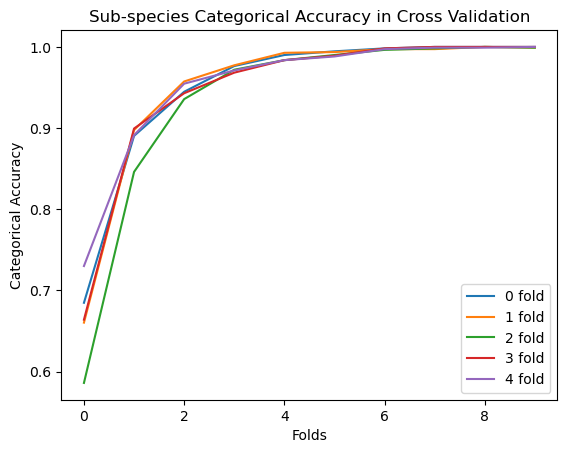

In [132]:
for i in range(folds):
    plt.plot(fold_histories[i].history['categorical_accuracy'], label=(str(i) + ' fold'))

plt.title('Sub-species Categorical Accuracy in Cross Validation')
plt.xlabel('Folds')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [133]:
print('Average evaluation accuracy: ', np.mean(eval_accuracy))
print('Average evaluation loss: ', np.mean(eval_loss))

Average evaluation accuracy:  0.9818840622901917
Average evaluation loss:  0.051552917808294296


## Analysis

Based on the above experimentation, the use of metadata to support local taxonomic decision making at the species and sub-species taxonomic level has proved succesful for similar looking species.

However the proboscidia dataset was limited such that it contained only 3 distinct species, and 4 sub-species. 

In order to further assess the effectiveness of meta-data classification at taxonomic levels, the Felids dataset will be utilized and analyzed at each taxonomic level in the `felid_taxonomy_analysis.ipynb` notebook in the `meta_modelling/` directory. This dataset consists of approximately 45 unique species providing a far larger, and more real-world dataset. Both the decision tree and neural network models will be used for testing purposes. 